In [1]:
import catboost
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import sweetviz

from sklearn.model_selection import train_test_split
from nflows.distributions import ConditionalDiagonalNormal

from src.probabilistic_flow_boosting.tfboost.tree import EmbeddableCatBoostPriorNormal
from src.probabilistic_flow_boosting.tfboost.tfboost import TreeFlowBoost
from src.probabilistic_flow_boosting.tfboost.flow import ContinuousNormalizingFlow
from src.probabilistic_flow_boosting.pipelines.reporting.nodes import calculate_nll

from src.probabilistic_flow_boosting.pipelines.modeling.utils import setup_random_seed

RANDOM_SEED = 42

setup_random_seed(RANDOM_SEED)

/opt/conda/lib/python3.6/site-packages/sweetviz/config.py:14: DeprecationWarning: open_text is deprecated. Use files() instead. Refer to https://importlib-resources.readthedocs.io/en/latest/using.html#migrating-from-legacy for migration advice.
  the_open = pkg_resources.open_text("sweetviz", 'sweetviz_defaults.ini')


In [2]:
df = pd.read_csv('data/01_raw/CatData/laptop/laptop_price.csv', index_col=0, engine='python')

In [3]:
df['Weight'] = pd.to_numeric(df['Weight'].str.replace('kg', ''))
df['Ram'] = pd.to_numeric(df['Ram'].str.replace('GB', ''))

                                             |          | [  0%]   00:00 -> (? left)


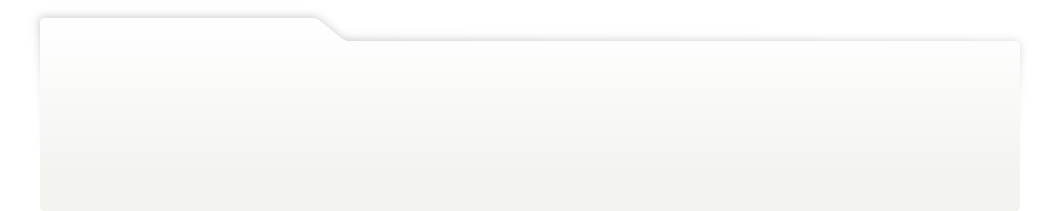
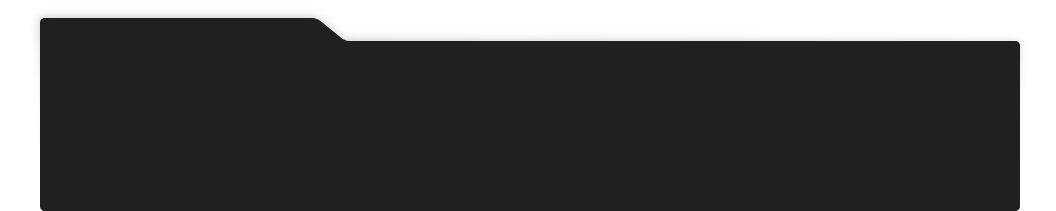
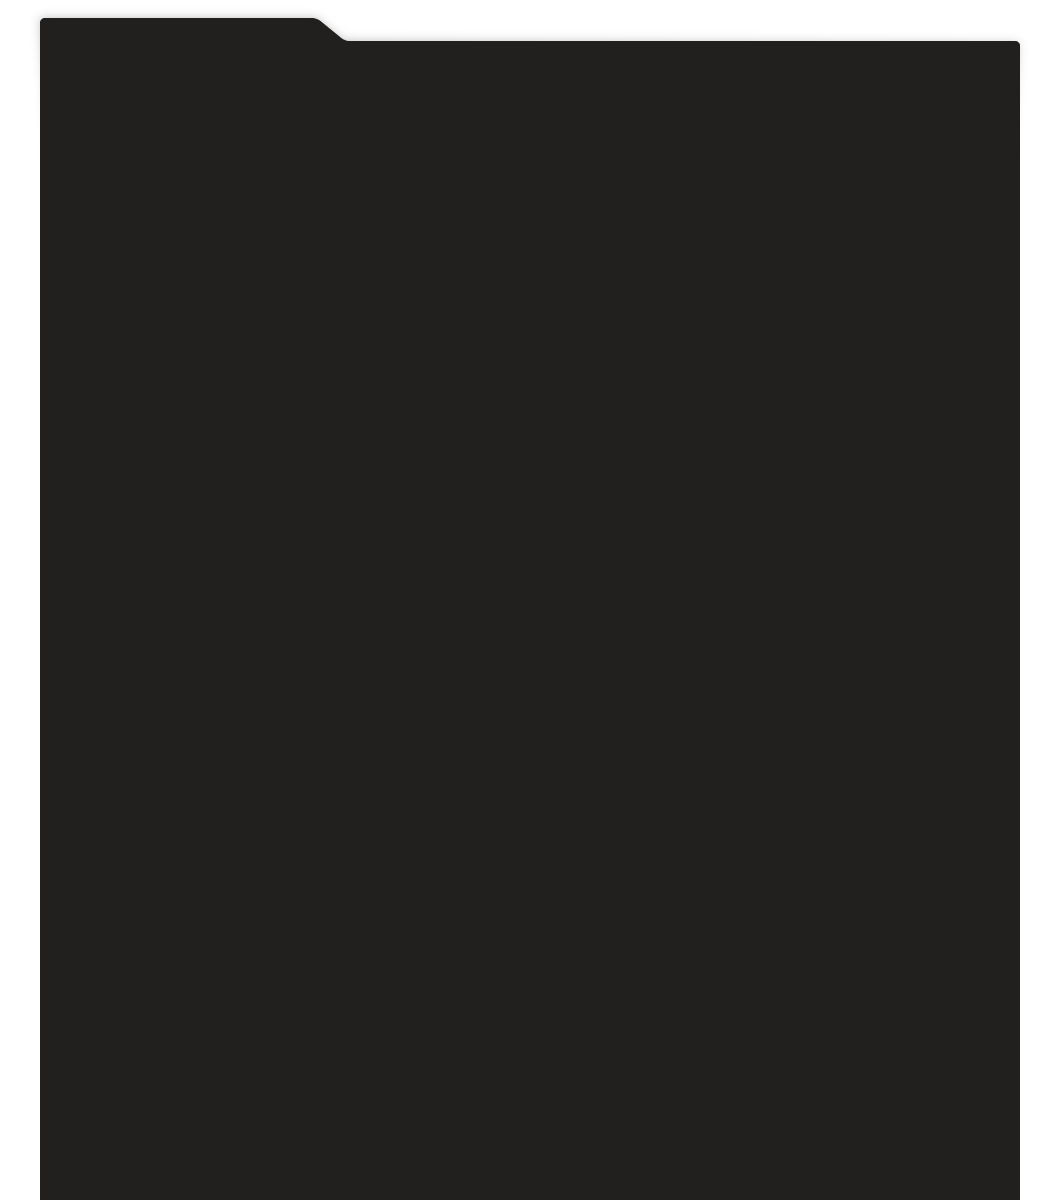
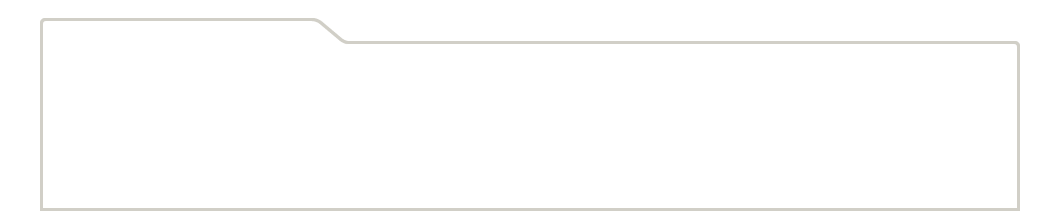
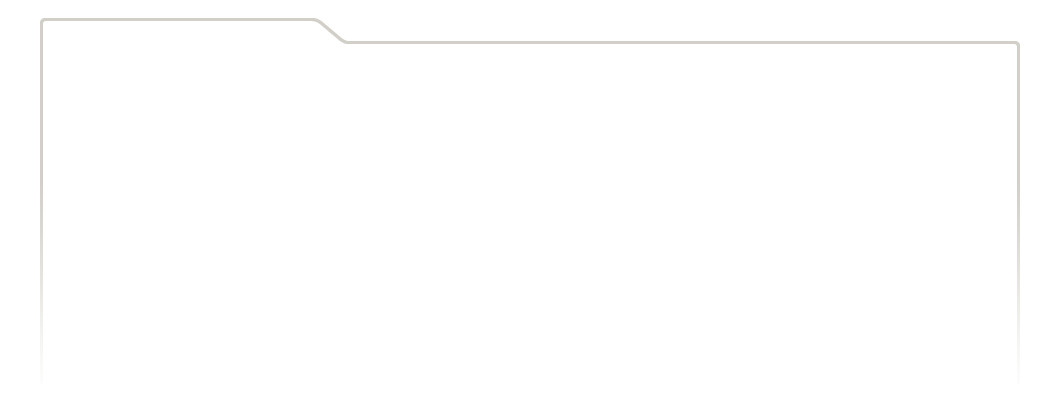
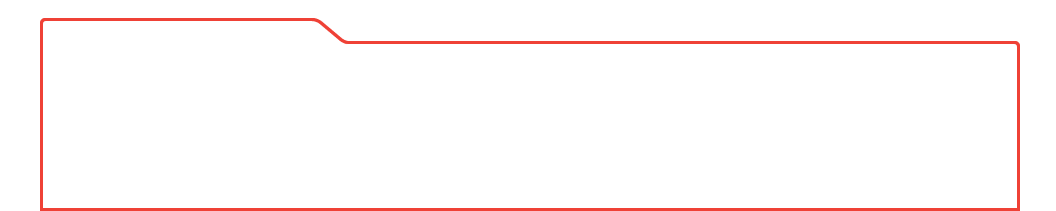
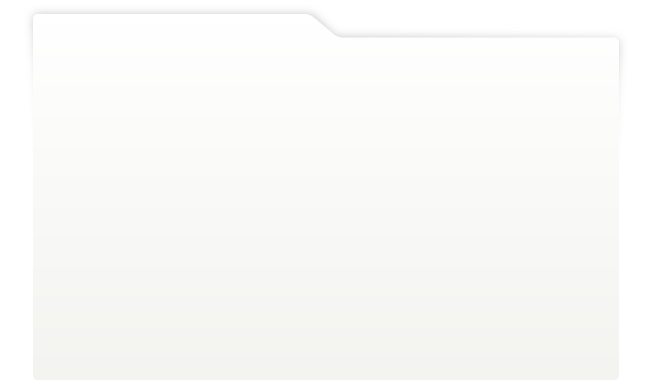
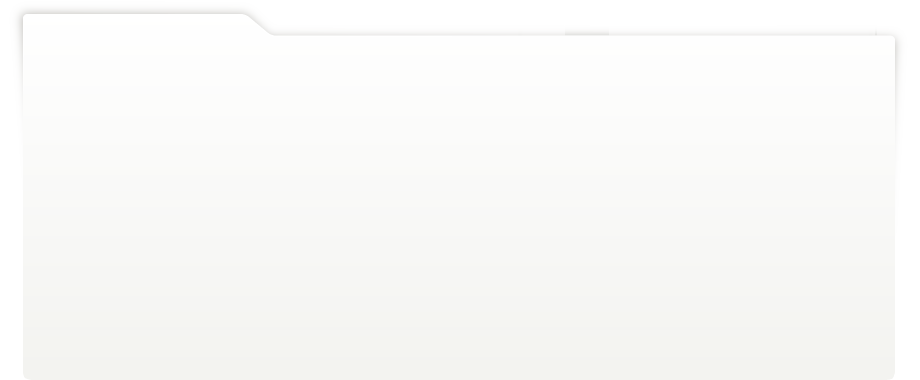
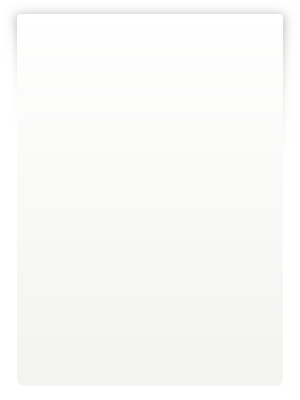
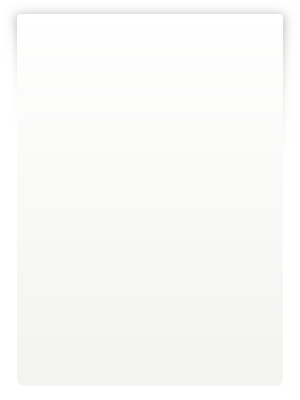
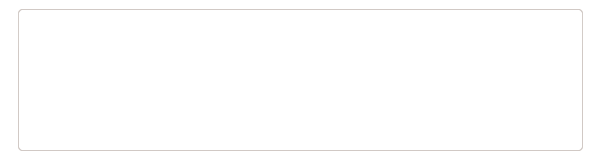
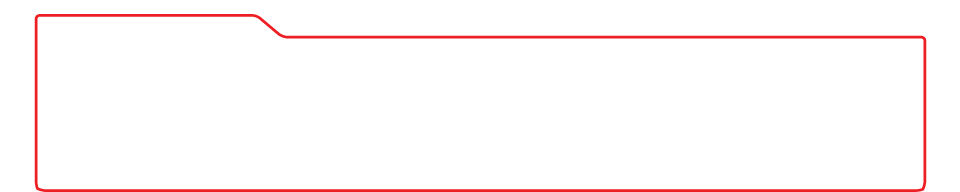
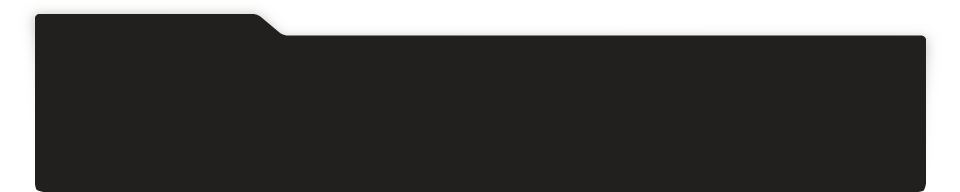
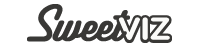
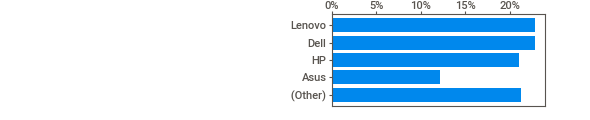
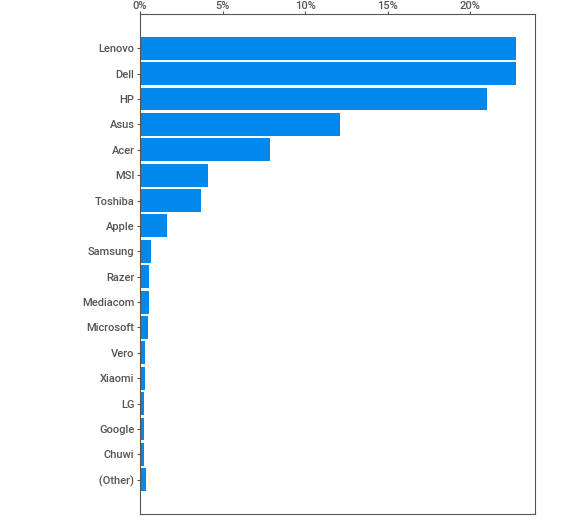
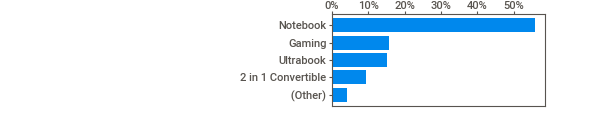
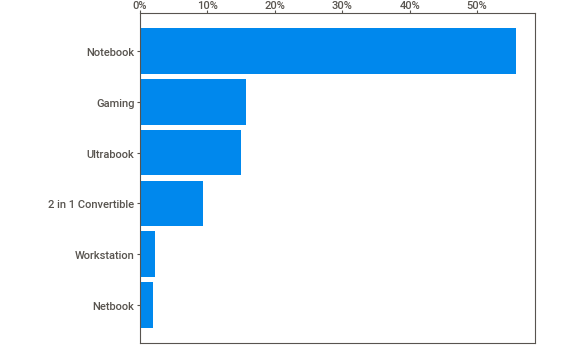
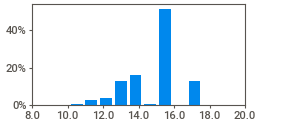
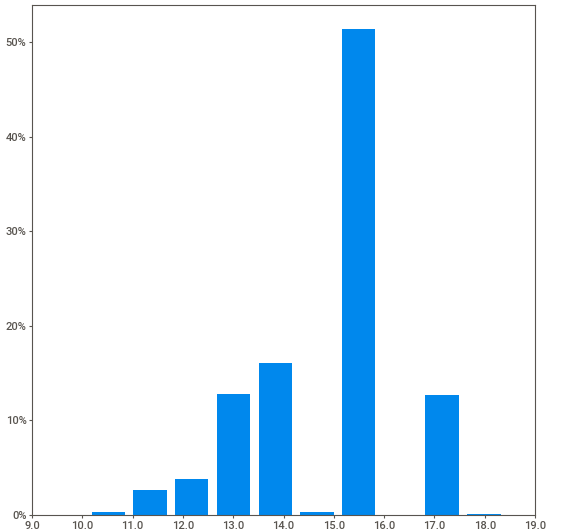
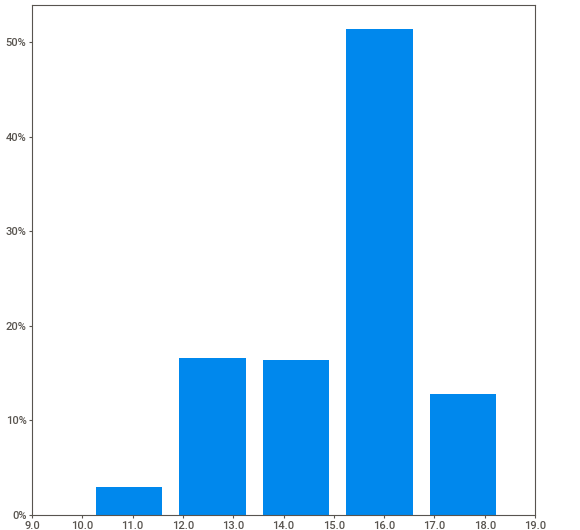
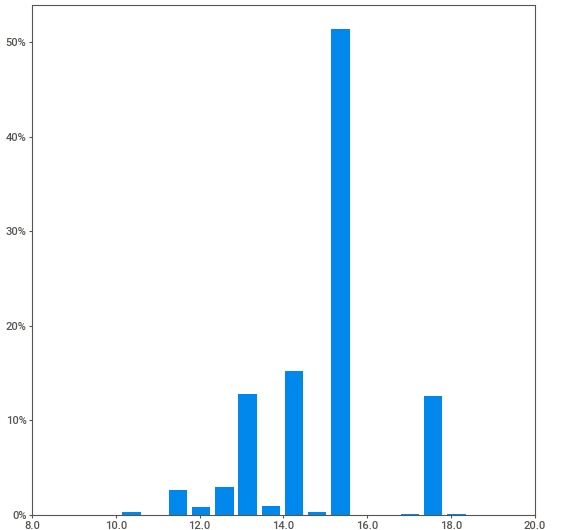
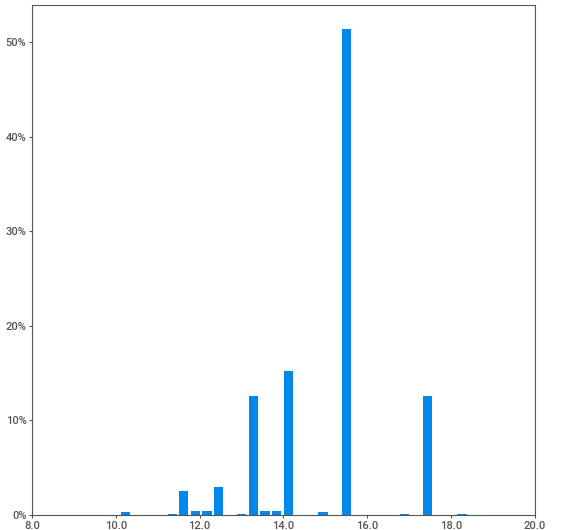
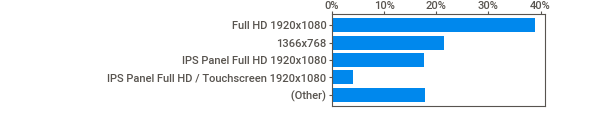
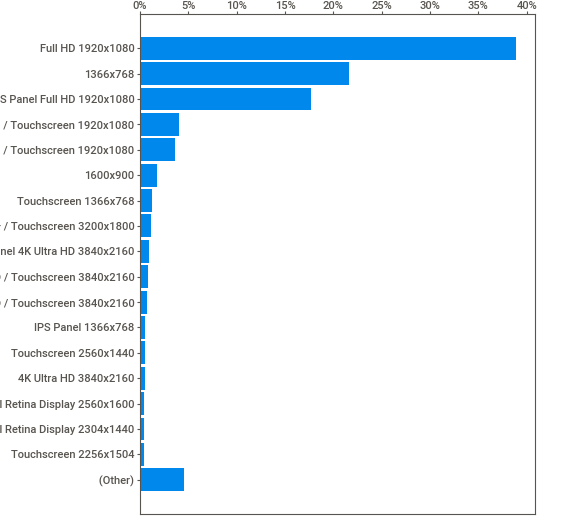
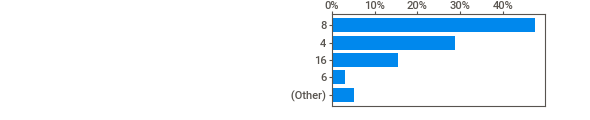
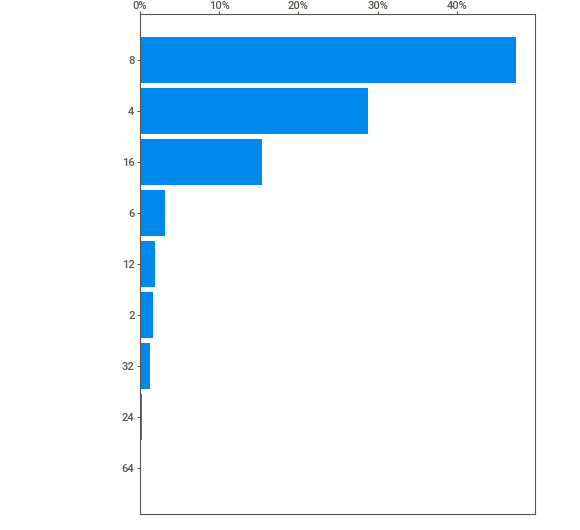
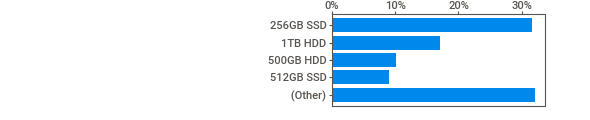
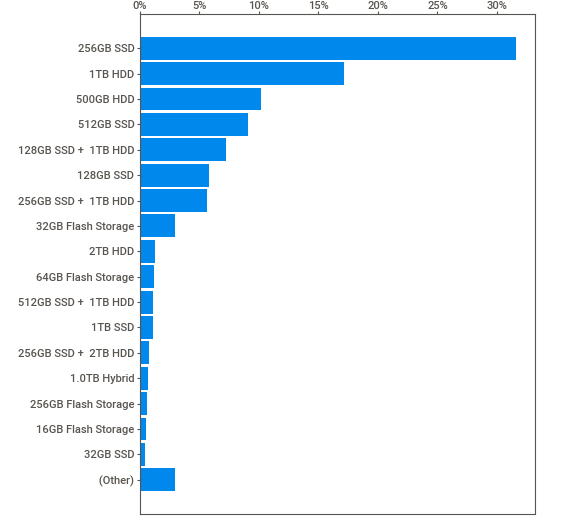
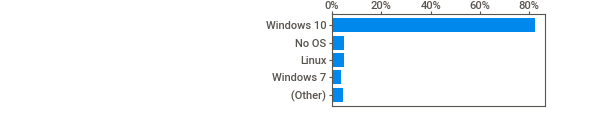
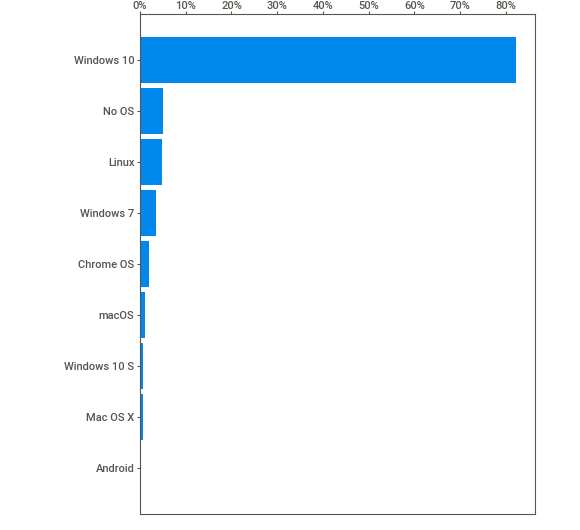
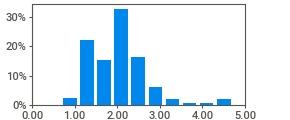
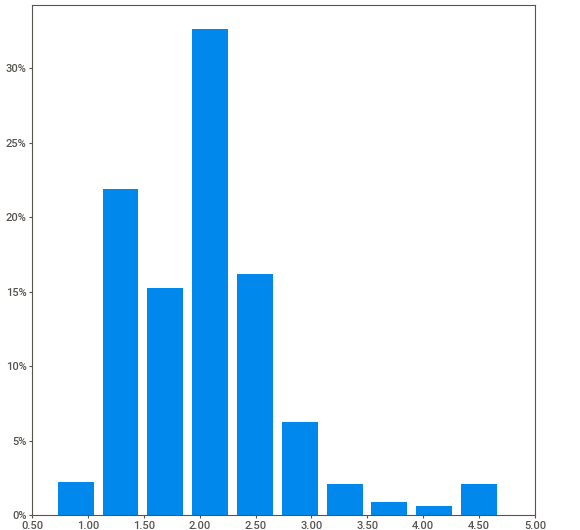
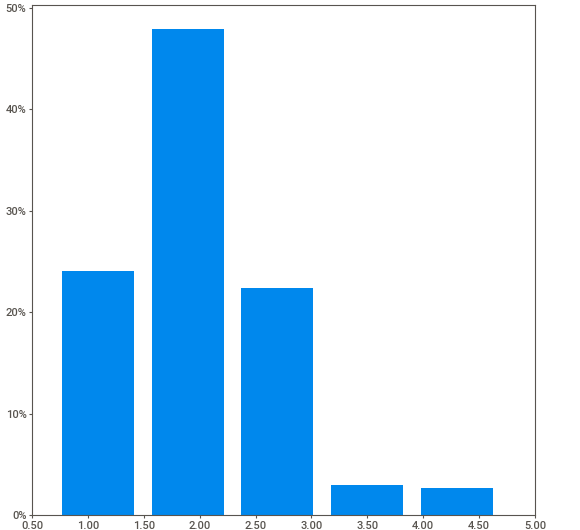
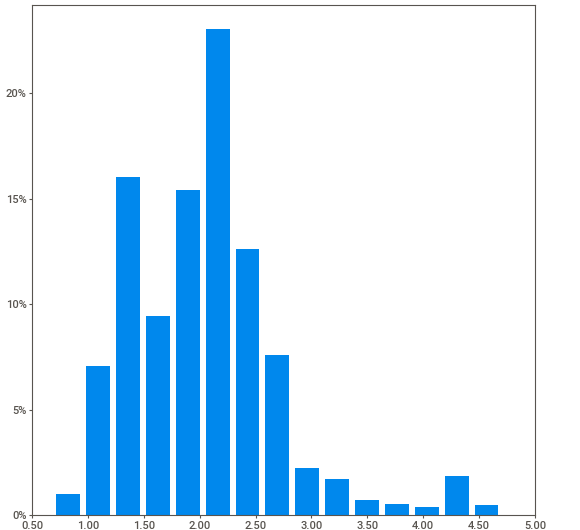
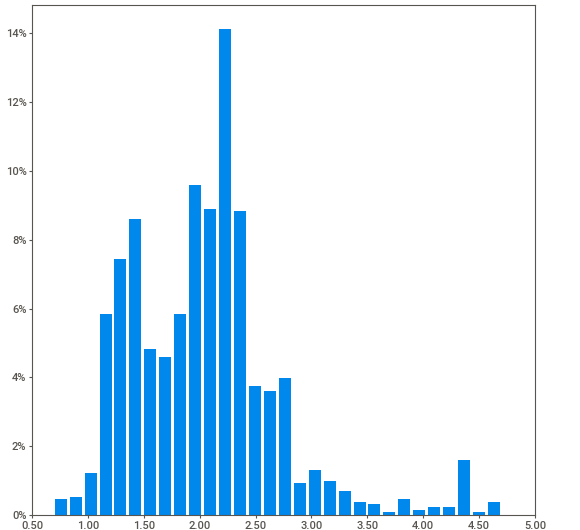
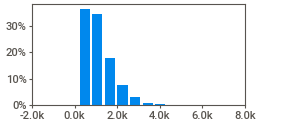
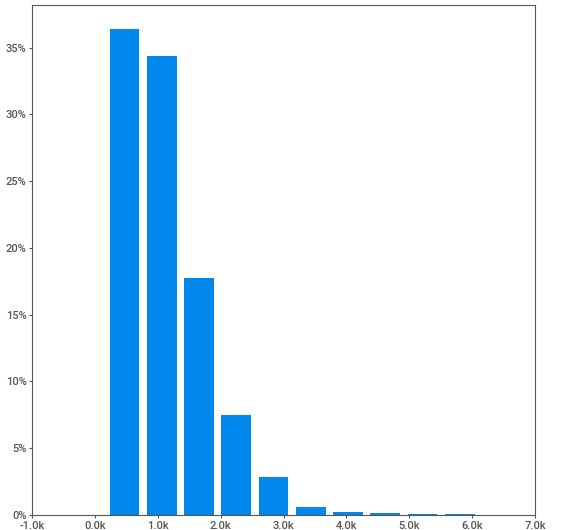
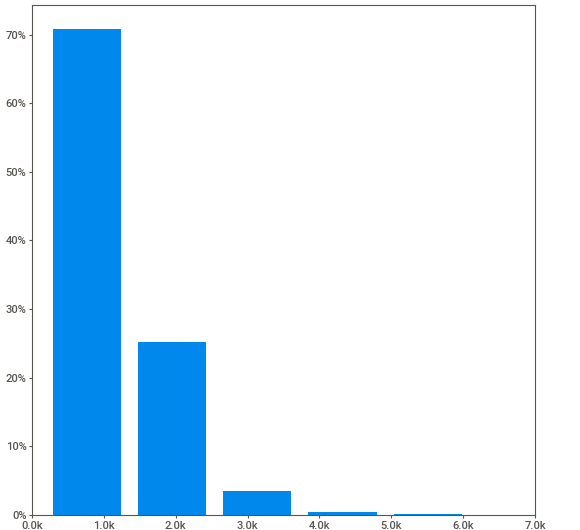
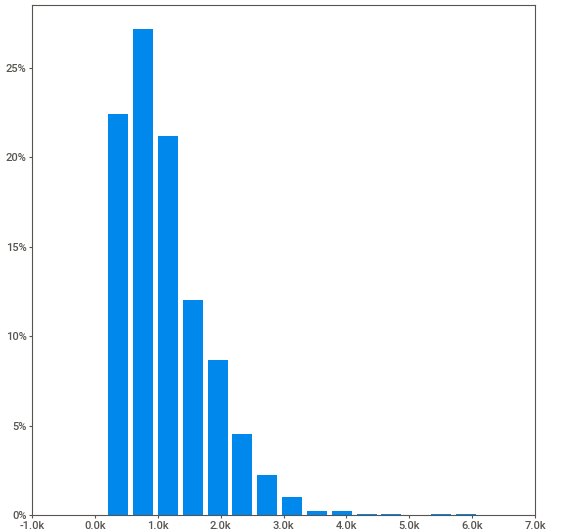
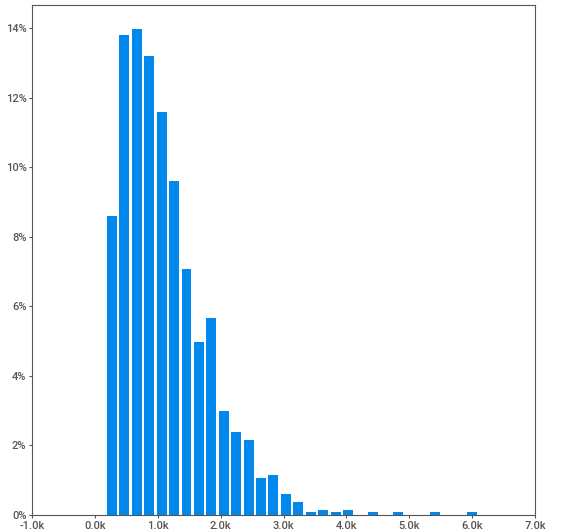
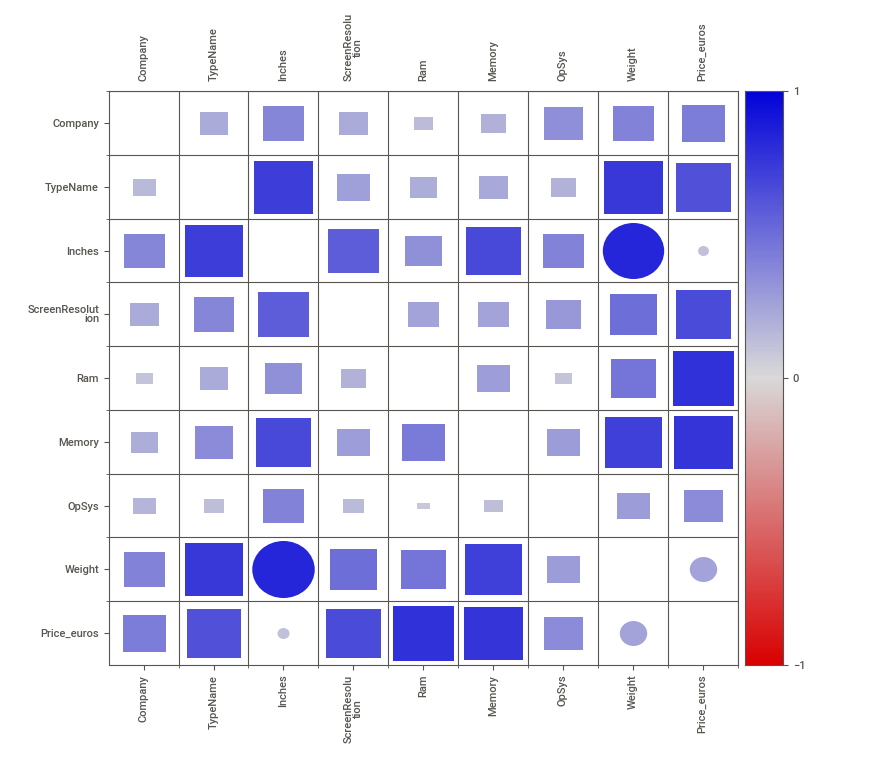
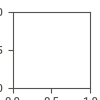

In [4]:
analysis = sweetviz.analyze(df)
analysis.show_notebook()

In [5]:
x = df.drop(columns = ['Product', 'Price_euros'])
y = np.log10(df[['Price_euros']])

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=42)

In [7]:
x_train.shape, x_test.shape

((1042, 10), (261, 10))

In [7]:
model = catboost.CatBoostRegressor(
    cat_features=['Company', 'TypeName', 'ScreenResolution', 'Cpu', 'Memory', 'Gpu', 'OpSys'], 
    loss_function="RMSEWithUncertainty",
    num_trees=2000
)

In [8]:
model.fit(x_tr, y_tr, eval_set=(x_val, y_val))

0:	learn: 0.0958284	test: 0.0859874	best: 0.0859874 (0)	total: 49.8ms	remaining: 1m 39s
1:	learn: 0.0670829	test: 0.0550898	best: 0.0550898 (1)	total: 53.2ms	remaining: 53.2s
2:	learn: 0.0453514	test: 0.0323329	best: 0.0323329 (2)	total: 67.1ms	remaining: 44.7s
3:	learn: 0.0215535	test: 0.0092975	best: 0.0092975 (3)	total: 69.8ms	remaining: 34.8s
4:	learn: -0.0027601	test: -0.0139912	best: -0.0139912 (4)	total: 71.9ms	remaining: 28.7s
5:	learn: -0.0209713	test: -0.0354786	best: -0.0354786 (5)	total: 73.8ms	remaining: 24.5s
6:	learn: -0.0376167	test: -0.0509143	best: -0.0509143 (6)	total: 75.8ms	remaining: 21.6s
7:	learn: -0.0560636	test: -0.0691506	best: -0.0691506 (7)	total: 77.4ms	remaining: 19.3s
8:	learn: -0.0750582	test: -0.0876284	best: -0.0876284 (8)	total: 79.5ms	remaining: 17.6s
9:	learn: -0.0921590	test: -0.1036086	best: -0.1036086 (9)	total: 81.3ms	remaining: 16.2s
10:	learn: -0.1062926	test: -0.1163432	best: -0.1163432 (10)	total: 82.8ms	remaining: 15s
11:	learn: -0.1219228

96:	learn: -0.7826271	test: -0.7252779	best: -0.7252779 (96)	total: 244ms	remaining: 4.78s
97:	learn: -0.7849979	test: -0.7280689	best: -0.7280689 (97)	total: 245ms	remaining: 4.75s
98:	learn: -0.7891625	test: -0.7302656	best: -0.7302656 (98)	total: 246ms	remaining: 4.72s
99:	learn: -0.7927975	test: -0.7307865	best: -0.7307865 (99)	total: 247ms	remaining: 4.7s
100:	learn: -0.7969637	test: -0.7323232	best: -0.7323232 (100)	total: 249ms	remaining: 4.67s
101:	learn: -0.7978773	test: -0.7324205	best: -0.7324205 (101)	total: 249ms	remaining: 4.63s
102:	learn: -0.8006327	test: -0.7350757	best: -0.7350757 (102)	total: 250ms	remaining: 4.61s
103:	learn: -0.8057054	test: -0.7391383	best: -0.7391383 (103)	total: 252ms	remaining: 4.59s
104:	learn: -0.8102252	test: -0.7419022	best: -0.7419022 (104)	total: 253ms	remaining: 4.57s
105:	learn: -0.8136735	test: -0.7422553	best: -0.7422553 (105)	total: 255ms	remaining: 4.55s
106:	learn: -0.8159891	test: -0.7448559	best: -0.7448559 (106)	total: 256ms	rem

208:	learn: -1.0740649	test: -0.8066345	best: -0.8140159 (190)	total: 440ms	remaining: 3.77s
209:	learn: -1.0764402	test: -0.8043398	best: -0.8140159 (190)	total: 442ms	remaining: 3.77s
210:	learn: -1.0781974	test: -0.8035141	best: -0.8140159 (190)	total: 444ms	remaining: 3.76s
211:	learn: -1.0803094	test: -0.8037384	best: -0.8140159 (190)	total: 447ms	remaining: 3.77s
212:	learn: -1.0820053	test: -0.8029900	best: -0.8140159 (190)	total: 450ms	remaining: 3.77s
213:	learn: -1.0836554	test: -0.8016482	best: -0.8140159 (190)	total: 452ms	remaining: 3.77s
214:	learn: -1.0862021	test: -0.8014664	best: -0.8140159 (190)	total: 455ms	remaining: 3.78s
215:	learn: -1.0879616	test: -0.8008646	best: -0.8140159 (190)	total: 457ms	remaining: 3.78s
216:	learn: -1.0900463	test: -0.8031237	best: -0.8140159 (190)	total: 459ms	remaining: 3.77s
217:	learn: -1.0921164	test: -0.8052770	best: -0.8140159 (190)	total: 461ms	remaining: 3.77s
218:	learn: -1.0936493	test: -0.8043908	best: -0.8140159 (190)	total: 

376:	learn: -1.3229590	test: -0.7493201	best: -0.8140159 (190)	total: 833ms	remaining: 3.59s
377:	learn: -1.3246210	test: -0.7474502	best: -0.8140159 (190)	total: 835ms	remaining: 3.58s
378:	learn: -1.3255097	test: -0.7452004	best: -0.8140159 (190)	total: 837ms	remaining: 3.58s
379:	learn: -1.3266705	test: -0.7423696	best: -0.8140159 (190)	total: 841ms	remaining: 3.58s
380:	learn: -1.3282651	test: -0.7400046	best: -0.8140159 (190)	total: 843ms	remaining: 3.58s
381:	learn: -1.3292383	test: -0.7407612	best: -0.8140159 (190)	total: 846ms	remaining: 3.58s
382:	learn: -1.3306880	test: -0.7394494	best: -0.8140159 (190)	total: 847ms	remaining: 3.58s
383:	learn: -1.3315638	test: -0.7376628	best: -0.8140159 (190)	total: 850ms	remaining: 3.58s
384:	learn: -1.3321241	test: -0.7367490	best: -0.8140159 (190)	total: 852ms	remaining: 3.58s
385:	learn: -1.3332780	test: -0.7343688	best: -0.8140159 (190)	total: 856ms	remaining: 3.58s
386:	learn: -1.3339719	test: -0.7336285	best: -0.8140159 (190)	total: 

539:	learn: -1.4819636	test: -0.4959257	best: -0.8140159 (190)	total: 1.23s	remaining: 3.32s
540:	learn: -1.4833756	test: -0.4947901	best: -0.8140159 (190)	total: 1.23s	remaining: 3.32s
541:	learn: -1.4838275	test: -0.4936687	best: -0.8140159 (190)	total: 1.24s	remaining: 3.32s
542:	learn: -1.4847196	test: -0.4908781	best: -0.8140159 (190)	total: 1.24s	remaining: 3.32s
543:	learn: -1.4858639	test: -0.4868588	best: -0.8140159 (190)	total: 1.24s	remaining: 3.31s
544:	learn: -1.4868986	test: -0.4856899	best: -0.8140159 (190)	total: 1.24s	remaining: 3.31s
545:	learn: -1.4877854	test: -0.4817609	best: -0.8140159 (190)	total: 1.24s	remaining: 3.31s
546:	learn: -1.4886774	test: -0.4782232	best: -0.8140159 (190)	total: 1.24s	remaining: 3.3s
547:	learn: -1.4895375	test: -0.4767413	best: -0.8140159 (190)	total: 1.24s	remaining: 3.3s
548:	learn: -1.4904897	test: -0.4754686	best: -0.8140159 (190)	total: 1.25s	remaining: 3.29s
549:	learn: -1.4922984	test: -0.4727009	best: -0.8140159 (190)	total: 1.

640:	learn: -1.5706951	test: -0.2425524	best: -0.8140159 (190)	total: 1.42s	remaining: 3.02s
641:	learn: -1.5714114	test: -0.2398377	best: -0.8140159 (190)	total: 1.43s	remaining: 3.02s
642:	learn: -1.5721459	test: -0.2402705	best: -0.8140159 (190)	total: 1.43s	remaining: 3.02s
643:	learn: -1.5725907	test: -0.2360071	best: -0.8140159 (190)	total: 1.43s	remaining: 3.01s
644:	learn: -1.5736910	test: -0.2338334	best: -0.8140159 (190)	total: 1.43s	remaining: 3.01s
645:	learn: -1.5740679	test: -0.2312395	best: -0.8140159 (190)	total: 1.43s	remaining: 3.01s
646:	learn: -1.5747239	test: -0.2306308	best: -0.8140159 (190)	total: 1.44s	remaining: 3s
647:	learn: -1.5757706	test: -0.2308648	best: -0.8140159 (190)	total: 1.44s	remaining: 3s
648:	learn: -1.5760278	test: -0.2280930	best: -0.8140159 (190)	total: 1.44s	remaining: 3s
649:	learn: -1.5766411	test: -0.2242706	best: -0.8140159 (190)	total: 1.44s	remaining: 3s
650:	learn: -1.5774988	test: -0.2209682	best: -0.8140159 (190)	total: 1.45s	remain

817:	learn: -1.6872264	test: 0.2450164	best: -0.8140159 (190)	total: 1.82s	remaining: 2.63s
818:	learn: -1.6877032	test: 0.2465052	best: -0.8140159 (190)	total: 1.82s	remaining: 2.63s
819:	learn: -1.6882509	test: 0.2466674	best: -0.8140159 (190)	total: 1.82s	remaining: 2.62s
820:	learn: -1.6884564	test: 0.2487347	best: -0.8140159 (190)	total: 1.83s	remaining: 2.62s
821:	learn: -1.6889707	test: 0.2515879	best: -0.8140159 (190)	total: 1.83s	remaining: 2.62s
822:	learn: -1.6893506	test: 0.2546343	best: -0.8140159 (190)	total: 1.83s	remaining: 2.62s
823:	learn: -1.6897305	test: 0.2574556	best: -0.8140159 (190)	total: 1.83s	remaining: 2.62s
824:	learn: -1.6899433	test: 0.2592588	best: -0.8140159 (190)	total: 1.84s	remaining: 2.62s
825:	learn: -1.6901062	test: 0.2605546	best: -0.8140159 (190)	total: 1.84s	remaining: 2.61s
826:	learn: -1.6906797	test: 0.2628480	best: -0.8140159 (190)	total: 1.84s	remaining: 2.61s
827:	learn: -1.6911608	test: 0.2640857	best: -0.8140159 (190)	total: 1.84s	remai

980:	learn: -1.7757506	test: 0.8562493	best: -0.8140159 (190)	total: 2.21s	remaining: 2.3s
981:	learn: -1.7758398	test: 0.8580623	best: -0.8140159 (190)	total: 2.21s	remaining: 2.29s
982:	learn: -1.7762886	test: 0.8597042	best: -0.8140159 (190)	total: 2.21s	remaining: 2.29s
983:	learn: -1.7767447	test: 0.8584483	best: -0.8140159 (190)	total: 2.22s	remaining: 2.29s
984:	learn: -1.7772358	test: 0.8590863	best: -0.8140159 (190)	total: 2.22s	remaining: 2.29s
985:	learn: -1.7778873	test: 0.8565334	best: -0.8140159 (190)	total: 2.22s	remaining: 2.28s
986:	learn: -1.7782920	test: 0.8610504	best: -0.8140159 (190)	total: 2.22s	remaining: 2.28s
987:	learn: -1.7786652	test: 0.8615615	best: -0.8140159 (190)	total: 2.23s	remaining: 2.28s
988:	learn: -1.7787074	test: 0.8666560	best: -0.8140159 (190)	total: 2.23s	remaining: 2.28s
989:	learn: -1.7793948	test: 0.8714133	best: -0.8140159 (190)	total: 2.23s	remaining: 2.27s
990:	learn: -1.7795934	test: 0.8677449	best: -0.8140159 (190)	total: 2.23s	remain

1158:	learn: -1.8787842	test: 1.5514809	best: -0.8140159 (190)	total: 2.6s	remaining: 1.89s
1159:	learn: -1.8792875	test: 1.5551736	best: -0.8140159 (190)	total: 2.61s	remaining: 1.89s
1160:	learn: -1.8797663	test: 1.5596809	best: -0.8140159 (190)	total: 2.61s	remaining: 1.89s
1161:	learn: -1.8802077	test: 1.5652813	best: -0.8140159 (190)	total: 2.61s	remaining: 1.88s
1162:	learn: -1.8807288	test: 1.5720731	best: -0.8140159 (190)	total: 2.61s	remaining: 1.88s
1163:	learn: -1.8811673	test: 1.5815217	best: -0.8140159 (190)	total: 2.61s	remaining: 1.88s
1164:	learn: -1.8817238	test: 1.5826135	best: -0.8140159 (190)	total: 2.62s	remaining: 1.88s
1165:	learn: -1.8826367	test: 1.5892092	best: -0.8140159 (190)	total: 2.62s	remaining: 1.87s
1166:	learn: -1.8831799	test: 1.5955752	best: -0.8140159 (190)	total: 2.62s	remaining: 1.87s
1167:	learn: -1.8836867	test: 1.6034791	best: -0.8140159 (190)	total: 2.62s	remaining: 1.87s
1168:	learn: -1.8841897	test: 1.6140625	best: -0.8140159 (190)	total: 2

1260:	learn: -1.9261806	test: 1.9632098	best: -0.8140159 (190)	total: 2.8s	remaining: 1.64s
1261:	learn: -1.9267963	test: 1.9680627	best: -0.8140159 (190)	total: 2.8s	remaining: 1.64s
1262:	learn: -1.9272005	test: 1.9746529	best: -0.8140159 (190)	total: 2.81s	remaining: 1.64s
1263:	learn: -1.9276097	test: 1.9782236	best: -0.8140159 (190)	total: 2.81s	remaining: 1.64s
1264:	learn: -1.9278162	test: 1.9846256	best: -0.8140159 (190)	total: 2.81s	remaining: 1.63s
1265:	learn: -1.9285172	test: 1.9966716	best: -0.8140159 (190)	total: 2.81s	remaining: 1.63s
1266:	learn: -1.9287529	test: 1.9989871	best: -0.8140159 (190)	total: 2.82s	remaining: 1.63s
1267:	learn: -1.9288737	test: 2.0037246	best: -0.8140159 (190)	total: 2.82s	remaining: 1.63s
1268:	learn: -1.9294516	test: 2.0027094	best: -0.8140159 (190)	total: 2.82s	remaining: 1.62s
1269:	learn: -1.9296681	test: 2.0041907	best: -0.8140159 (190)	total: 2.82s	remaining: 1.62s
1270:	learn: -1.9300432	test: 2.0137509	best: -0.8140159 (190)	total: 2.

1360:	learn: -1.9699120	test: 2.3436766	best: -0.8140159 (190)	total: 3s	remaining: 1.41s
1361:	learn: -1.9702952	test: 2.3534653	best: -0.8140159 (190)	total: 3s	remaining: 1.41s
1362:	learn: -1.9708846	test: 2.3635465	best: -0.8140159 (190)	total: 3s	remaining: 1.4s
1363:	learn: -1.9719149	test: 2.3759148	best: -0.8140159 (190)	total: 3.01s	remaining: 1.4s
1364:	learn: -1.9726538	test: 2.3750245	best: -0.8140159 (190)	total: 3.01s	remaining: 1.4s
1365:	learn: -1.9730131	test: 2.3745163	best: -0.8140159 (190)	total: 3.01s	remaining: 1.4s
1366:	learn: -1.9732602	test: 2.3841158	best: -0.8140159 (190)	total: 3.01s	remaining: 1.39s
1367:	learn: -1.9736522	test: 2.3883629	best: -0.8140159 (190)	total: 3.01s	remaining: 1.39s
1368:	learn: -1.9744779	test: 2.3946277	best: -0.8140159 (190)	total: 3.02s	remaining: 1.39s
1369:	learn: -1.9746820	test: 2.4053576	best: -0.8140159 (190)	total: 3.02s	remaining: 1.39s
1370:	learn: -1.9751706	test: 2.4123714	best: -0.8140159 (190)	total: 3.02s	remaini

1526:	learn: -2.0489432	test: 3.3891773	best: -0.8140159 (190)	total: 3.39s	remaining: 1.05s
1527:	learn: -2.0494032	test: 3.3943550	best: -0.8140159 (190)	total: 3.39s	remaining: 1.05s
1528:	learn: -2.0502813	test: 3.3879019	best: -0.8140159 (190)	total: 3.4s	remaining: 1.05s
1529:	learn: -2.0507546	test: 3.4002824	best: -0.8140159 (190)	total: 3.4s	remaining: 1.04s
1530:	learn: -2.0516383	test: 3.4086960	best: -0.8140159 (190)	total: 3.4s	remaining: 1.04s
1531:	learn: -2.0526149	test: 3.4104607	best: -0.8140159 (190)	total: 3.4s	remaining: 1.04s
1532:	learn: -2.0531327	test: 3.4198874	best: -0.8140159 (190)	total: 3.4s	remaining: 1.04s
1533:	learn: -2.0534735	test: 3.4247313	best: -0.8140159 (190)	total: 3.41s	remaining: 1.03s
1534:	learn: -2.0540230	test: 3.4281545	best: -0.8140159 (190)	total: 3.41s	remaining: 1.03s
1535:	learn: -2.0547367	test: 3.4304168	best: -0.8140159 (190)	total: 3.41s	remaining: 1.03s
1536:	learn: -2.0553855	test: 3.4325988	best: -0.8140159 (190)	total: 3.41s

1691:	learn: -2.1390027	test: 4.7251541	best: -0.8140159 (190)	total: 3.79s	remaining: 690ms
1692:	learn: -2.1394950	test: 4.7483675	best: -0.8140159 (190)	total: 3.79s	remaining: 687ms
1693:	learn: -2.1399510	test: 4.7576908	best: -0.8140159 (190)	total: 3.79s	remaining: 685ms
1694:	learn: -2.1400769	test: 4.7671158	best: -0.8140159 (190)	total: 3.79s	remaining: 683ms
1695:	learn: -2.1405260	test: 4.7718199	best: -0.8140159 (190)	total: 3.8s	remaining: 681ms
1696:	learn: -2.1411738	test: 4.7792527	best: -0.8140159 (190)	total: 3.8s	remaining: 678ms
1697:	learn: -2.1417920	test: 4.7851832	best: -0.8140159 (190)	total: 3.8s	remaining: 676ms
1698:	learn: -2.1421069	test: 4.7921151	best: -0.8140159 (190)	total: 3.81s	remaining: 674ms
1699:	learn: -2.1422686	test: 4.7966715	best: -0.8140159 (190)	total: 3.81s	remaining: 672ms
1700:	learn: -2.1427040	test: 4.8001101	best: -0.8140159 (190)	total: 3.81s	remaining: 670ms
1701:	learn: -2.1431523	test: 4.8134083	best: -0.8140159 (190)	total: 3.8

1869:	learn: -2.2152712	test: 6.8436991	best: -0.8140159 (190)	total: 4.18s	remaining: 291ms
1870:	learn: -2.2156614	test: 6.8454391	best: -0.8140159 (190)	total: 4.18s	remaining: 288ms
1871:	learn: -2.2166308	test: 6.8512939	best: -0.8140159 (190)	total: 4.18s	remaining: 286ms
1872:	learn: -2.2169722	test: 6.8652783	best: -0.8140159 (190)	total: 4.19s	remaining: 284ms
1873:	learn: -2.2173650	test: 6.8647516	best: -0.8140159 (190)	total: 4.19s	remaining: 282ms
1874:	learn: -2.2174732	test: 6.8764562	best: -0.8140159 (190)	total: 4.19s	remaining: 279ms
1875:	learn: -2.2174078	test: 6.8894286	best: -0.8140159 (190)	total: 4.19s	remaining: 277ms
1876:	learn: -2.2173806	test: 6.8993532	best: -0.8140159 (190)	total: 4.2s	remaining: 275ms
1877:	learn: -2.2174725	test: 6.9127582	best: -0.8140159 (190)	total: 4.2s	remaining: 273ms
1878:	learn: -2.2184081	test: 6.9281120	best: -0.8140159 (190)	total: 4.2s	remaining: 271ms
1879:	learn: -2.2184428	test: 6.9484175	best: -0.8140159 (190)	total: 4.2

1959:	learn: -2.2550992	test: 8.2402112	best: -0.8140159 (190)	total: 4.38s	remaining: 89.3ms
1960:	learn: -2.2552279	test: 8.2555011	best: -0.8140159 (190)	total: 4.38s	remaining: 87.1ms
1961:	learn: -2.2554058	test: 8.2990976	best: -0.8140159 (190)	total: 4.38s	remaining: 84.8ms
1962:	learn: -2.2565088	test: 8.3029928	best: -0.8140159 (190)	total: 4.38s	remaining: 82.6ms
1963:	learn: -2.2572233	test: 8.3078905	best: -0.8140159 (190)	total: 4.38s	remaining: 80.4ms
1964:	learn: -2.2575743	test: 8.3063395	best: -0.8140159 (190)	total: 4.38s	remaining: 78.1ms
1965:	learn: -2.2581141	test: 8.3201671	best: -0.8140159 (190)	total: 4.39s	remaining: 75.9ms
1966:	learn: -2.2596020	test: 8.3344756	best: -0.8140159 (190)	total: 4.39s	remaining: 73.6ms
1967:	learn: -2.2598156	test: 8.3657167	best: -0.8140159 (190)	total: 4.39s	remaining: 71.4ms
1968:	learn: -2.2598386	test: 8.3831670	best: -0.8140159 (190)	total: 4.39s	remaining: 69.2ms
1969:	learn: -2.2599959	test: 8.4287985	best: -0.8140159 (19

In [9]:
def calculate_nll_catboost(model: catboost.CatBoostRegressor, x: pd.DataFrame, y: pd.DataFrame):
    x: np.ndarray = x.values
    y: np.ndarray = y.values

    if y.shape[1] > 1:
        return np.nan

    y_hat_tree = model.predict(x)
    y_hat_tree[:, 1] = np.log(np.sqrt(y_hat_tree[:, 1]))  # Transform var to log std / CatBoost RMSEWithUncertainty

    distribution = ConditionalDiagonalNormal(shape=[1])  # Assume 1D distribution
    return -distribution.log_prob(y, y_hat_tree).numpy().mean()

In [10]:
calculate_nll_catboost(model, x_train, y_train)

-0.9897476346909765

In [11]:
calculate_nll_catboost(model, x_test, y_test)

-0.8386516330701419

In [13]:
tree = EmbeddableCatBoostPriorNormal(
    cat_features=[0, 1, 3, 4, 6, 7, 8], 
    loss_function="RMSEWithUncertainty",
    depth=1,
    num_trees=500,
    random_state=RANDOM_SEED
)
flow = ContinuousNormalizingFlow(input_dim=1, hidden_dims=(100, 100, 50), context_dim=100, conditional=True)

treeflow = TreeFlowBoost(tree, flow, embedding_size=100)

In [14]:
treeflow.fit(x_tr.values, y_tr.values, x_val.values, y_val.values, n_epochs=100, batch_size=1024, verbose=True)

0:	learn: 0.1201910	total: 511us	remaining: 255ms
1:	learn: 0.1159774	total: 1.1ms	remaining: 273ms
2:	learn: 0.1016096	total: 1.75ms	remaining: 289ms
3:	learn: 0.0895037	total: 2.11ms	remaining: 261ms
4:	learn: 0.0790924	total: 2.45ms	remaining: 242ms
5:	learn: 0.0685824	total: 2.79ms	remaining: 230ms
6:	learn: 0.0589986	total: 3.19ms	remaining: 225ms
7:	learn: 0.0543084	total: 3.55ms	remaining: 218ms
8:	learn: 0.0453700	total: 3.89ms	remaining: 212ms
9:	learn: 0.0349070	total: 4.26ms	remaining: 209ms
10:	learn: 0.0277881	total: 4.65ms	remaining: 207ms
11:	learn: 0.0239074	total: 5.03ms	remaining: 205ms
12:	learn: 0.0157628	total: 5.37ms	remaining: 201ms
13:	learn: 0.0130608	total: 5.72ms	remaining: 199ms
14:	learn: 0.0040044	total: 6.02ms	remaining: 195ms
15:	learn: -0.0037942	total: 6.33ms	remaining: 192ms
16:	learn: -0.0110763	total: 6.66ms	remaining: 189ms
17:	learn: -0.0176776	total: 7ms	remaining: 187ms
18:	learn: -0.0258920	total: 7.3ms	remaining: 185ms
19:	learn: -0.0320164	to

train loss: 1.1816614866256714
val loss: 0.6625563502311707
train loss: 1.3124563694000244
val loss: 1.5992828607559204
train loss: 1.235655665397644
val loss: 1.681050181388855
train loss: 0.15726961195468903
val loss: 0.6149807572364807
train loss: 0.25472399592399597
val loss: 0.29045236110687256
train loss: 0.38326776027679443
val loss: 0.24589374661445618
train loss: 0.23485016822814941
val loss: 0.1823423057794571
train loss: 0.14375092089176178
val loss: 0.14129430055618286
train loss: 0.10876215994358063
val loss: 0.13438352942466736
train loss: 0.0923418328166008
val loss: 0.12709712982177734
train loss: 0.0769147276878357
val loss: 0.1104024276137352
train loss: 0.06127241998910904
val loss: 0.09590032696723938
train loss: 0.03932496905326843
val loss: 0.076945960521698
train loss: 0.016743429005146027
val loss: 0.060915905982255936
train loss: -0.008469482883810997
val loss: 0.042735505849123
train loss: -0.03542717918753624
val loss: 0.019992928951978683
train loss: -0.0652

TreeFlowBoost(embedding_size=100,
              flow_model=<src.probabilistic_flow_boosting.tfboost.flow.flow.ContinuousNormalizingFlow object at 0x7fc8ddaec710>,
              tree_model=<src.probabilistic_flow_boosting.tfboost.tree.ecatboost.EmbeddableCatBoostPriorNormal object at 0x7fc8ddaecb70>)

In [15]:
calculate_nll(treeflow, x_train, y_train, batch_size = 1024)

-1.0043126

In [16]:
calculate_nll(treeflow, x_test, y_test, batch_size = 1024)

-0.96126205

In [17]:
data = x_test.iloc[:10, :]

In [18]:
y_test_catboost = model.predict(data)

y_test_samples = treeflow.sample(data, num_samples=1000)
y_test_samples = y_test_samples.squeeze()

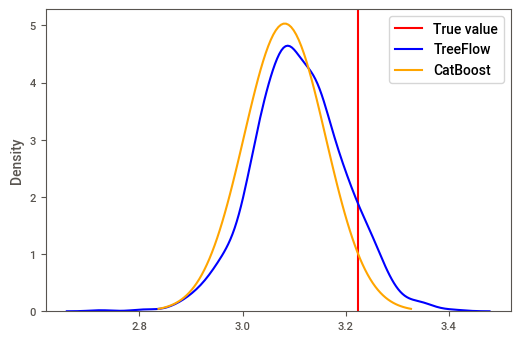

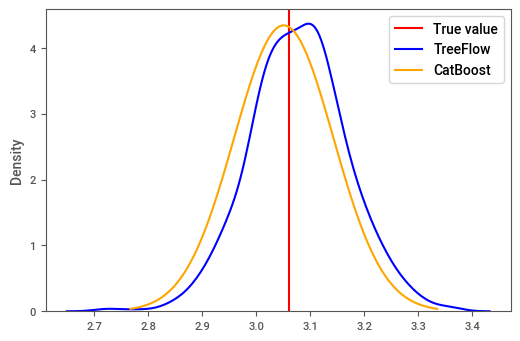

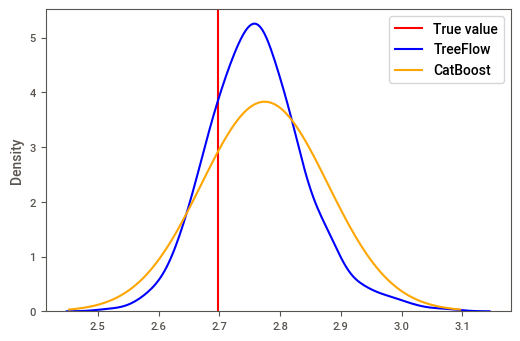

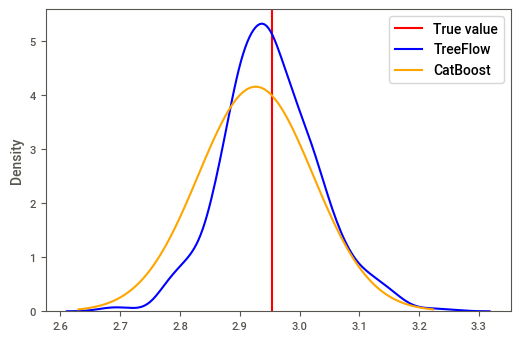

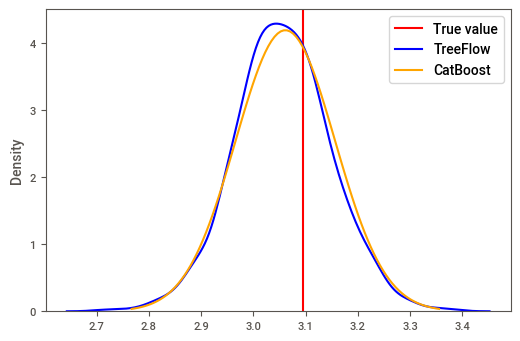

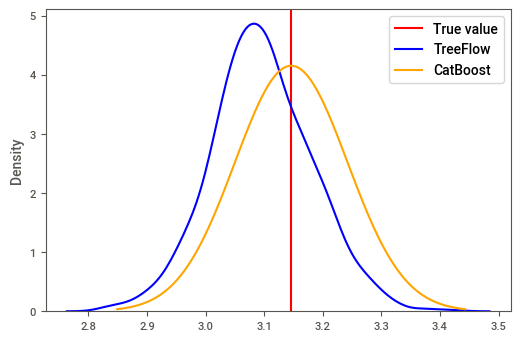

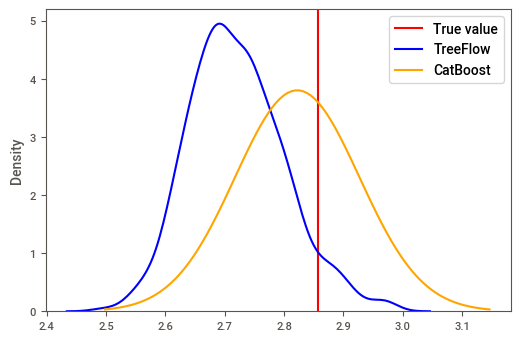

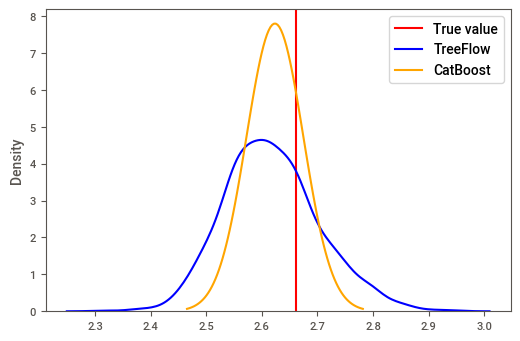

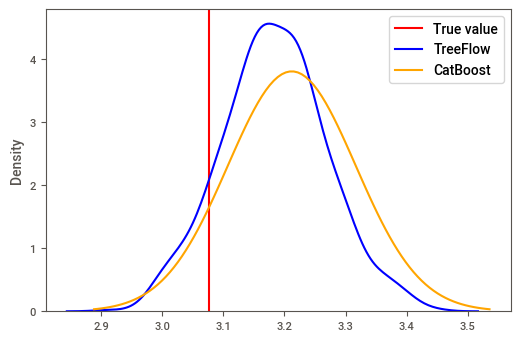

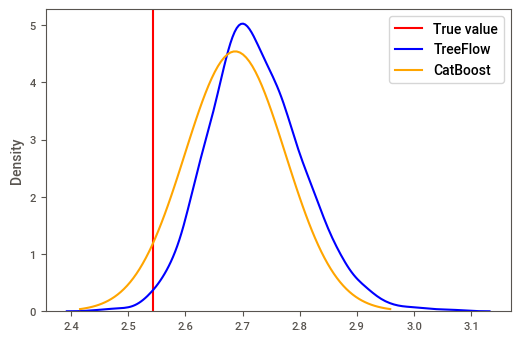

In [19]:
for i in range(10):
    plt.axvline(x=y_test.values[i, :], color='r', label='True value')

    sns.kdeplot(y_test_samples[i, :], color='blue', label='TreeFlow')

    x = np.linspace(
        stats.norm.ppf(0.001, loc=y_test_catboost[i, 0], scale=np.sqrt(y_test_catboost[i, 1])), 
        stats.norm.ppf(0.999, loc=y_test_catboost[i, 0], scale=np.sqrt(y_test_catboost[i, 1])), 
        100
    )
    plt.plot(x, stats.norm.pdf(x, loc=y_test_catboost[i, 0], scale=np.sqrt(y_test_catboost[i, 1])), color = 'orange', label='CatBoost')

    plt.legend()
    plt.show()